## BloomTech Data Science

---

# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [ ]:
# %%capture
# !pip install category_encoders==2.*

In [ ]:
# from category_encoders import OrdinalEncoder
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer
# from sklearn.metrics import ConfusionMatrixDisplay, classification_report
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import pandas as pd

# Downloading the Tanzania Waterpump Dataset

Make sure  you only use the dataset that is available through the **DS** **Kaggle Competition**. DO NOT USE any other Tanzania waterpump datasets that you might find online.

There are two ways you can get the dataset. Make sure you have joined the competition first!:

1. You can download the dataset directly by accessing the challenge and the files through the Kaggle Competition URL on Canvas (make sure you have joined the competition!)

2. Use the Kaggle API using the code in the following cells. This article provides helpful information on how to fetch your Kaggle Dataset into Google Colab using the Kaggle API.

> https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

# Using Kaggle API to download datset

In [ ]:
# # mounting your google drive on colab
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change your working directory, if you want to or have already saved your kaggle dataset on google drive.
# %cd /content/gdrive/My Drive/Kaggle
# update it to your folder location on drive that contains the dataset and/or kaggle API token json file.

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so.
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c bloomtech-water-pump-challenge

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [ ]:
# List all files in your Kaggle folder on your google drive.
# !ls

sample_submission.csv  test_features.csv  train_features.csv  train_labels.csv


# I. Wrangle Data

In [4]:
import pandas as pd
import numpy as np
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path,
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')
    df['needs_repair'] = np.where(df['status_group']=='functional',0,1)
    

  else:

    df = pd.read_csv(fm_path,
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')


  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns # check for atleast a 100 values
  dupe_cols = [col for col in df.head(100).T.duplicated().index
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)

  return df

df = wrangle(fm_path='C:/Users/ISHMO_CT/Downloads/Classification-metrics/Data-sets/train_features.csv',
             tv_path='C:/Users/ISHMO_CT/Downloads/Classification-metrics/Data-sets/train_labels.csv')

X_test = wrangle(fm_path='C:/Users/ISHMO_CT/Downloads/Classification-metrics/Data-sets/test_features.csv')

## EDA


In [ ]:
# Classify into pumps that need repair and pumps that do not need repairs.
# functional - class 0
# non functional, functional needs repair - class 1

In [ ]:
# OPTION 1
# np.where(df['status_group']=='functional',0,1)
#NOTE : Added the code the wrangle function

In [ ]:
# OPTION 2
# (df['status_group'] != 'functional').astype(int)

In [ ]:
# OPTION 3
# df['status_group'].apply(lambda x: 0 if x=='functional' else 1)

In [ ]:
# Have a look at 

# II. Split Data

In [6]:
# Split TV / FM
from sklearn.model_selection import train_test_split
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [7]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


# Build Model


In [14]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators = 25, n_jobs = -1, random_state = 42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
                                          'data_type': dtype('O'),
                                          'mapping': hand pump             1
communal standpipe    2
improved spring       3
other                 4
cattle trough         5
dam                   6
NaN                  -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=25, n_jobs=-1,
                                        random_state=42))])

# Check Metrics

**Accuracy Score**

In [15]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9985532026831514
Validation Accuracy: 0.9554924242424242


# Interlude: Beware or Leakage

If you leave `'status_group'` in your feature matrix, you'll have **leakage**.

<Axes: >

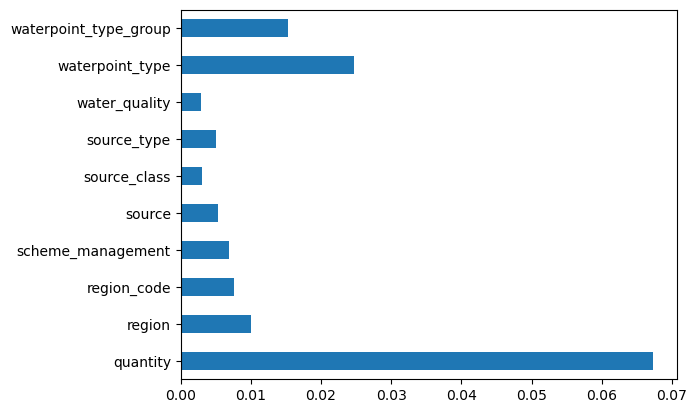

In [18]:
import matplotlib.pyplot as plt
feature_importance = model.named_steps['randomforestclassifier'].feature_importances_
features =X_train.columns
pd.Series(feature_importance, index=features).sort_index().tail(10).plot(kind = 'barh')

# Check Metrics

**Accuracy Score**

In [ ]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

**Confusion Matrix**

In [ ]:
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator

**Precision Score**

Of all the pumps that you predicted as needing repair, what proportion actually needed repair?

In [ ]:
# precision = tp / (tp + fp)

**Recall Score**

Of those pumps that actually needed repair, what proportion did you correctly predict as needing repair?

In [ ]:
# recall tp/(tp+fn)

**Classification Report**

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections.

Scenario 1: Choose pumps randomly

In [ ]:

print('Inspections conducted:',)
print('Pumps repaired:', )
print('Funds wasted:', )

Scenario 2: Using our model "out of the box"

In [ ]:
data = {
    'y_val':y_val,
    'y_pred':
}

results =pd.DataFrame(data)

In [ ]:
print('Inspections conducted:',)
print('Pumps repaired:',  )
print('Funds wasted:',)

Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.85`) need repair.

In [ ]:
data = {
    'y_val':y_val,
    'y_pred_proba':
}

results =pd.DataFrame(data)

In [ ]:
print('Inspections conducted:', )
print('Pumps repaired:', )
print('Funds wasted:', )
